In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

In [ ]:
train_cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
train_quant = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
train_target = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')
train_func = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')

test_cat = pd.read_excel('/content/TEST_CATEGORICAL.xlsx')
test_quant = pd.read_excel('/content/TEST_QUANTITATIVE_METADATA.xlsx')
test_func = pd.read_csv('/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')

In [ ]:
train = train_cat.merge(train_quant, on='participant_id', how='inner')
train = train.merge(train_target, on='participant_id', how='inner')
train = train.merge(train_func, on='participant_id', how='inner')

test = test_cat.merge(test_quant, on='participant_id', how='inner')
test = test.merge(test_func, on='participant_id', how='inner')

In [ ]:
imaging_cols = [col for col in train.columns if col.startswith('0throw') or col.startswith('1throw')]
non_imaging_cols = [col for col in train.columns if col not in imaging_cols + ['participant_id', 'ADHD_Outcome', 'Sex_F']]


sdq_cols = [col for col in non_imaging_cols if 'SDQ' in col]

In [ ]:
imputer = SimpleImputer(strategy='median')
train[non_imaging_cols] = imputer.fit_transform(train[non_imaging_cols])
test[non_imaging_cols] = imputer.transform(test[non_imaging_cols])

scaler = StandardScaler()
train_imaging_scaled = scaler.fit_transform(train[imaging_cols])
test_imaging_scaled = scaler.transform(test[imaging_cols])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90)

train_pca = pca.fit_transform(train_imaging_scaled)
test_pca = pca.transform(test_imaging_scaled)


In [ ]:
train_combined = np.hstack([train_pca, train[sdq_cols]])
test_combined = np.hstack([test_pca, test[sdq_cols]])

y_sex = train['Sex_F']
y_adhd = train['ADHD_Outcome']

In [ ]:
xgb_params_sex = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'eval_metric': 'logloss',
    'scale_pos_weight': len(y_sex[y_sex == 0]) / len(y_sex[y_sex == 1]),
    'random_state': SEED
}

xgb_params_adhd = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'eval_metric': 'logloss',
    'scale_pos_weight': len(y_adhd[y_adhd == 0]) / len(y_adhd[y_adhd == 1]),
    'random_state': SEED
}

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

cv_scores_sex = []
cv_scores_adhd = []

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

print("Sex label distribution:", np.bincount(y_sex))
print("ADHD label distribution:", np.bincount(y_adhd))

run_sex = len(np.unique(y_sex)) >= 2 and np.min(np.bincount(y_sex)) >= 2
run_adhd = len(np.unique(y_adhd)) >= 2 and np.min(np.bincount(y_adhd)) >= 2

if not run_sex:
    print("Sex labels have fewer than 2 samples in one class. Skipping Sex model.")
if not run_adhd:
    print("ADHD labels have fewer than 2 samples in one class. Skipping ADHD model.")

cv_scores_sex = []
cv_scores_adhd = []

if run_sex:
    n_splits_sex = min(3, np.min(np.bincount(y_sex)))
    cv_sex = StratifiedKFold(n_splits=n_splits_sex, shuffle=True, random_state=42)

    for train_idx, val_idx in cv_sex.split(train_combined, y_sex):
        X_train, X_val = train_combined[train_idx], train_combined[val_idx]
        y_train, y_val = y_sex.iloc[train_idx], y_sex.iloc[val_idx]

        model = XGBClassifier(**xgb_params_sex)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        cv_scores_sex.append(f1_score(y_val, y_pred))

if run_adhd:
    n_splits_adhd = min(3, np.min(np.bincount(y_adhd)))
    cv_adhd = StratifiedKFold(n_splits=n_splits_adhd, shuffle=True, random_state=42)

    for train_idx, val_idx in cv_adhd.split(train_combined, y_adhd):
        X_train, X_val = train_combined[train_idx], train_combined[val_idx]
        y_train, y_val = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]

        model = XGBClassifier(**xgb_params_adhd)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        cv_scores_adhd.append(f1_score(y_val, y_pred))

if run_sex:
    print(f"CV F1 Score (Sex): {np.mean(cv_scores_sex):.4f} ± {np.std(cv_scores_sex):.4f}")
if run_adhd:
    print(f"CV F1 Score (ADHD): {np.mean(cv_scores_adhd):.4f} ± {np.std(cv_scores_adhd):.4f}")


Sex label distribution: [27 12]
ADHD label distribution: [11 28]
CV F1 Score (Sex): 0.3016 ± 0.0224
CV F1 Score (ADHD): 0.8772 ± 0.0496


In [ ]:
model_sex_final = XGBClassifier(**xgb_params_sex)
model_sex_final.fit(train_combined, y_sex)
train['sex_proba'] = model_sex_final.predict_proba(train_combined)[:, 1]

for col in sdq_cols:
    train[f"I_{col}"] = train[col] * train['sex_proba']

if run_adhd:
    train_with_interactions = train.drop(['ADHD_Outcome', 'Sex_F', 'participant_id'], axis=1)

    model_adhd_final = XGBClassifier(**xgb_params_adhd)
    model_adhd_final.fit(train_with_interactions, y_adhd)
else:
    print("Skipping ADHD model training due to only one class in y_adhd.")


In [ ]:
n_components = train_pca.shape[1]

train_pca_df = pd.DataFrame(train_pca, columns=[f'pca_{i}' for i in range(n_components)])

train_with_pca = pd.concat([train_pca_df, train[sdq_cols].reset_index(drop=True)], axis=1)

train_with_pca['sex_proba'] = model_sex_final.predict_proba(train_with_pca)[:, 1]


In [ ]:
for col in sdq_cols:
    train_with_pca[f"I_{col}"] = train_with_pca[col] * train_with_pca["sex_proba"]

In [ ]:
test_pca = pca.transform(test_imaging_scaled)

test_pca_df = pd.DataFrame(test_pca, columns=[f'pca_{i}' for i in range(test_pca.shape[1])])

test_with_pca = pd.concat([test_pca_df, test[sdq_cols].reset_index(drop=True)], axis=1)

test_with_pca['sex_proba'] = model_sex_final.predict_proba(test_with_pca)[:, 1]

for col in sdq_cols:
    test_with_pca[f"I_{col}"] = test_with_pca[col] * test_with_pca["sex_proba"]


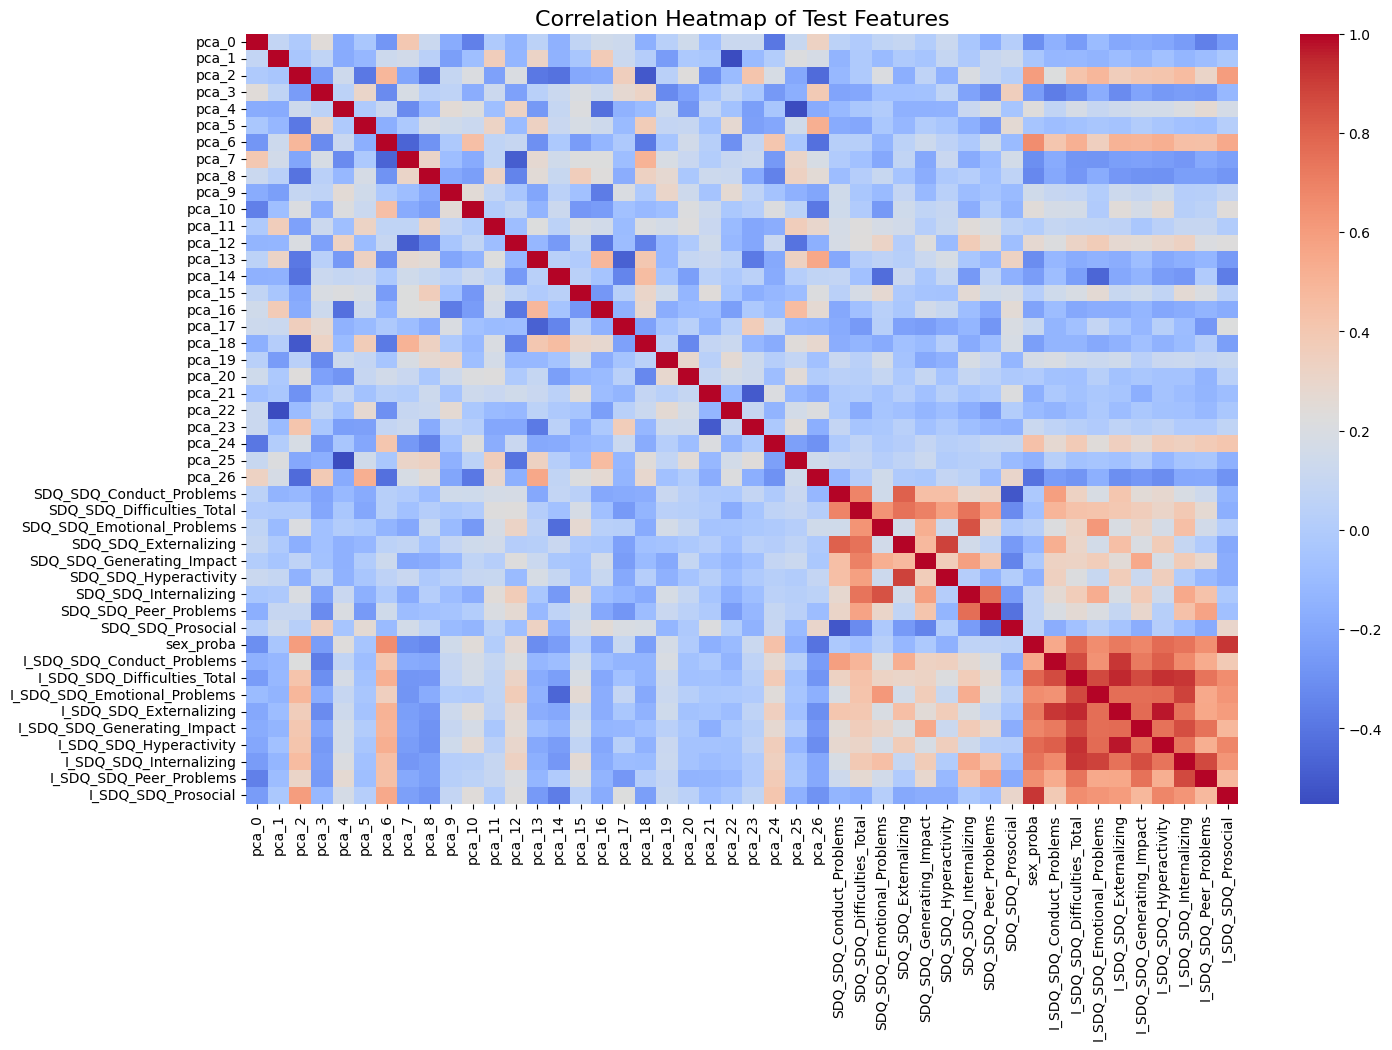

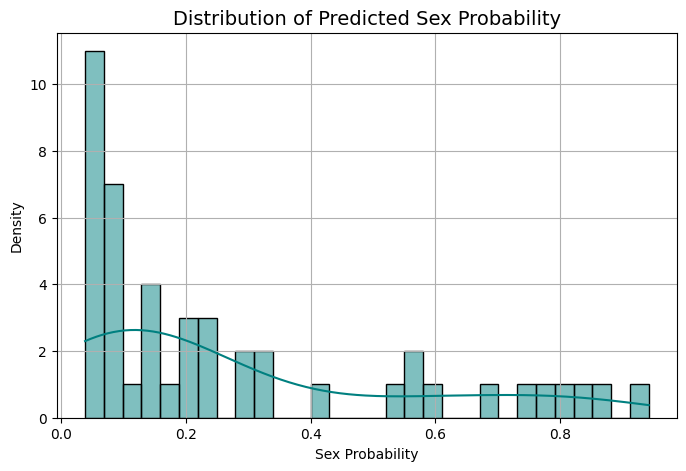

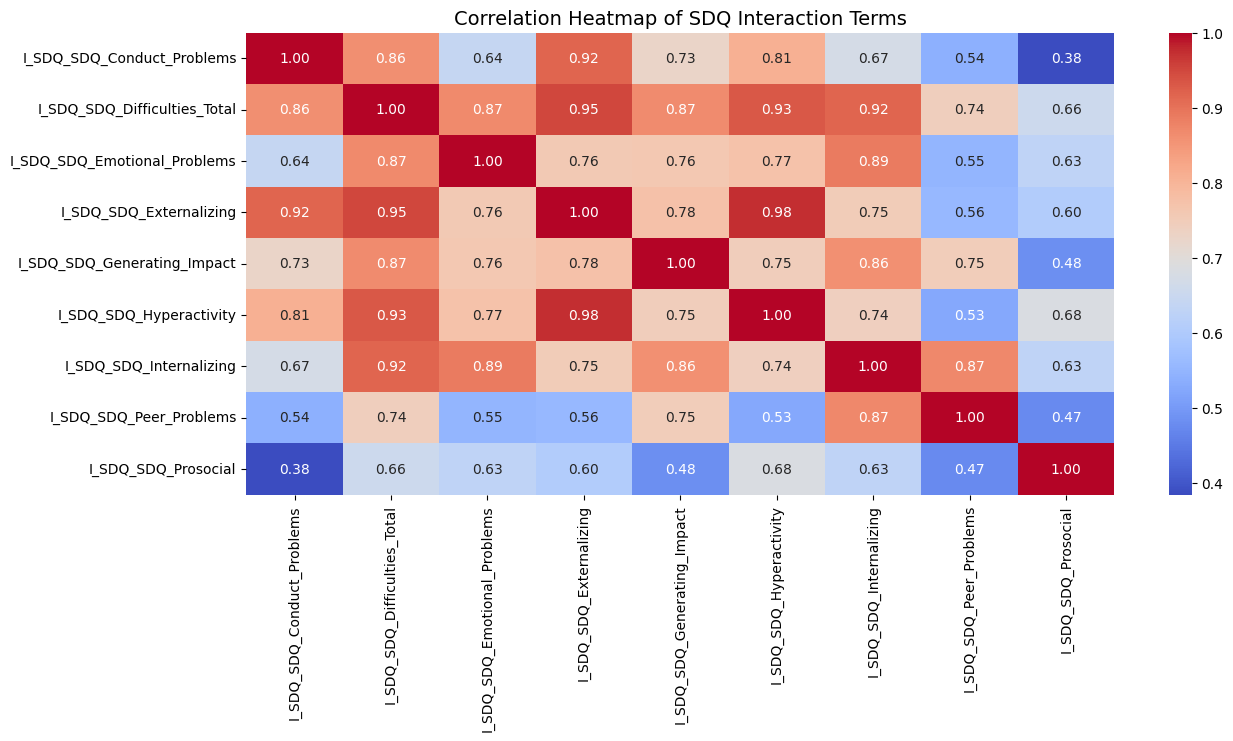

ValueError: Length of values (36) does not match length of index (46)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(16, 10))
corr_matrix = test_with_pca.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Correlation Heatmap of Test Features", fontsize=16)
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(test_with_pca['sex_proba'], kde=True, bins=30, color='teal')
plt.title("Distribution of Predicted Sex Probability", fontsize=14)
plt.xlabel("Sex Probability")
plt.ylabel("Density")
plt.grid(True)
plt.show()

interaction_cols = [f"I_{col}" for col in sdq_cols]
plt.figure(figsize=(14, 6))
sns.heatmap(test_with_pca[interaction_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of SDQ Interaction Terms", fontsize=14)
plt.show()

importances = model_sex_final.feature_importances_
feature_names = train_with_pca.columns
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feat_importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Sex Model)')
plt.xlabel('Importance Score')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_[:50]), marker='o')
plt.title("Cumulative Explained Variance by PCA Components", fontsize=14)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

selected_cols = ['sex_proba'] + sdq_cols[:2] + interaction_cols[:2] + [f'pca_{i}' for i in range(2)]
sns.pairplot(test_with_pca[selected_cols])
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()


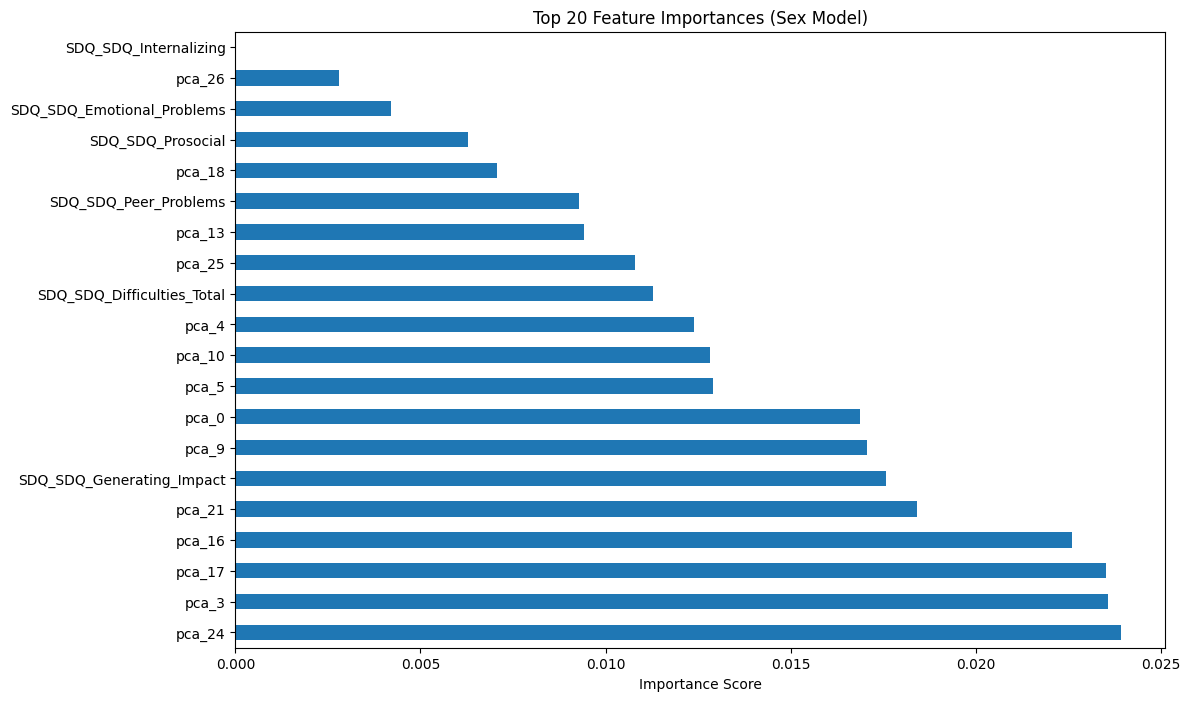

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model_sex_final.feature_importances_

trained_feature_names = train_with_pca.columns[:len(importances)]

feat_importances = pd.Series(importances, index=trained_feature_names)
feat_importances = feat_importances.sort_values(ascending=True)  # ascending for barh

plt.figure(figsize=(12, 8))
feat_importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Sex Model)')
plt.xlabel('Importance Score')
plt.show()


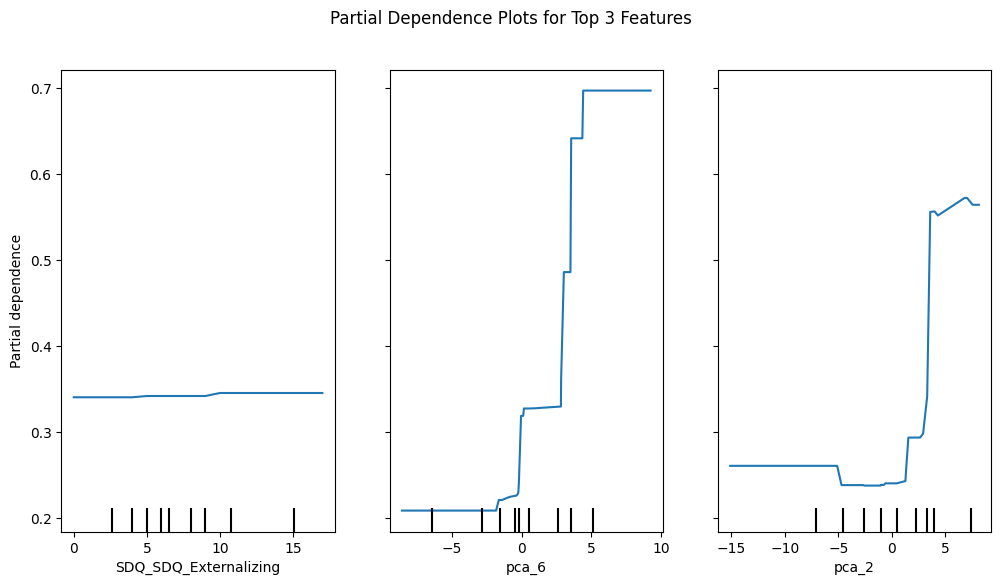

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay

importances = model_sex_final.feature_importances_

trained_features = train_with_pca.columns[:len(importances)]

feat_importances = pd.Series(importances, index=trained_features).sort_values(ascending=False)

top_features = feat_importances.head(3).index.tolist()

X_subset = train_with_pca[trained_features]

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model_sex_final, X_subset, features=top_features, ax=ax)
plt.suptitle('Partial Dependence Plots for Top 3 Features')
plt.show()
